# Tumour Hypoxia Measurement 
.. as an application-specific downstream image analysis task to judge the utility of synthetic HX4-PET.

Three different ways used here to evauluate tumour hypoxia signature:
1. Basic image similarity metrics applied locally within the tumour: MSE and SSIM
2. Hypoxia Classification accuracy
3. Hypoxia segmentation Dice

In [27]:
import time

import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity

import SimpleITK as sitk
from viz_utils import NdimageVisualizer

In [3]:
visualizer = NdimageVisualizer()

## Metrics, hypoxia calculation functions, utils

In [25]:
# mse(), ssim() and create_masked_array() functions taken from midaGAN

def mse(gt, pred):
    mae_value = np.mean(np.abs(gt - pred))
    return float(mae_value)

def ssim(gt, pred, maxval=None):
    """Compute Structural Similarity Index Metric (SSIM)"""
    maxval = gt.max() if maxval is None else maxval

    size = (gt.shape[0] * gt.shape[1]) if gt.ndim == 4 else gt.shape[0]

    ssim_sum = 0
    for channel in range(gt.shape[0]):
        # Format is CxHxW or DxHxW
        if gt.ndim == 3:
            target = gt[channel]
            prediction = pred[channel]
            ssim_sum += structural_similarity(target, prediction, data_range=maxval)

        # Format is CxDxHxW
        elif gt.ndim == 4:
            for slice_num in range(gt.shape[1]):
                target = gt[channel, slice_num]
                prediction = pred[channel, slice_num]
                ssim_sum += structural_similarity(target, prediction, data_range=maxval)
        else:
            raise NotImplementedError(f"SSIM for {gt.ndim} images not implemented")

    return ssim_sum / size


In [39]:
def dice_score(image_1, image_2):
    dice = 2 * np.sum(image_1 * image_2) / (image_1.sum() + image_2.sum())
    return float(dice)

In [21]:
def crop_image_to_tumour_size(image, gtv_mask):
    gtv_voxel_coords = np.argwhere(gtv_mask)
    z1, y1, x1 = gtv_voxel_coords[:, 0].min(), gtv_voxel_coords[:, 1].min(), gtv_voxel_coords[:, 2].min()
    z2, y2, x2 = gtv_voxel_coords[:, 0].max(), gtv_voxel_coords[:, 1].max(), gtv_voxel_coords[:, 2].max()
    return image[z1:z2, y1:y2, x1:x2]


def create_masked_array(input, mask):
    """
    Create a masked array after applying the respective mask. 
    This mask array will filter values across different operations such as mean
    """
#     mask = mask.detach().cpu().numpy()

    mask = mask.astype(np.bool)
    # Masked array needs negated masks as it decides
    # what element to ignore based on True values
    negated_mask = ~mask
    return np.ma.masked_array(input * mask, mask=negated_mask)

## Run

In [8]:
DATA_ROOT_DIR = "/home/chinmay/Datasets/HX4-PET-Translation"
RESULTS_ROOT_DIR = "/home/chinmay/Projects-Work/HX4-PET-Translation/Results"
HX4_TBR_MIN, HX4_TBR_MAX = 0.0, 3.0

SAMPLE_PATIENT = "N010"
MODEL_NAME = "hx4_pet_pix2pix_lambda10"
CHECKPOINT_NUMBER = 60000

In [18]:
# Read images
pred_image_file = f"{RESULTS_ROOT_DIR}/HX4-PET-Translation/{MODEL_NAME}/val/saved/{str(CHECKPOINT_NUMBER)}/{SAMPLE_PATIENT}.nrrd"
hx4_pet_reg_file = f"{DATA_ROOT_DIR}/Processed/val/{SAMPLE_PATIENT}/hx4_pet_reg.nrrd"
gtv_mask_file = f"{DATA_ROOT_DIR}/Processed/val/{SAMPLE_PATIENT}/pct_gtv.nrrd"
body_mask_file = f"{DATA_ROOT_DIR}/Processed/val/{SAMPLE_PATIENT}/pct_body.nrrd"

pred = sitk.GetArrayFromImage(sitk.ReadImage(pred_image_file))
hx4_pet_reg = sitk.GetArrayFromImage(sitk.ReadImage(hx4_pet_reg_file))
gtv_mask = sitk.GetArrayFromImage(sitk.ReadImage(gtv_mask_file))
body_mask = sitk.GetArrayFromImage(sitk.ReadImage(body_mask_file))

# Normlalize with SUVmean_aorta
suv_mean_aorta_file = f"{DATA_ROOT_DIR}/SUVmean_aorta_HX4.csv"
suv_aorta_mean_values = pd.read_csv(suv_mean_aorta_file, index_col=0)
suv_aorta_mean_values = suv_aorta_mean_values.to_dict()['HX4 aorta SUVmean baseline']
suv_aorta_mean = suv_aorta_mean_values[SAMPLE_PATIENT]

pred = pred / suv_aorta_mean
hx4_pet_reg = hx4_pet_reg / suv_aorta_mean

# Clip TBR values to given range
pred = np.clip(pred, HX4_TBR_MIN, HX4_TBR_MAX)
hx4_pet_reg = np.clip(hx4_pet_reg, HX4_TBR_MIN, HX4_TBR_MAX)

# Apply body mask to gt
hx4_pet_reg = hx4_pet_reg * body_mask


(40, 500, 500)
(40, 500, 500)


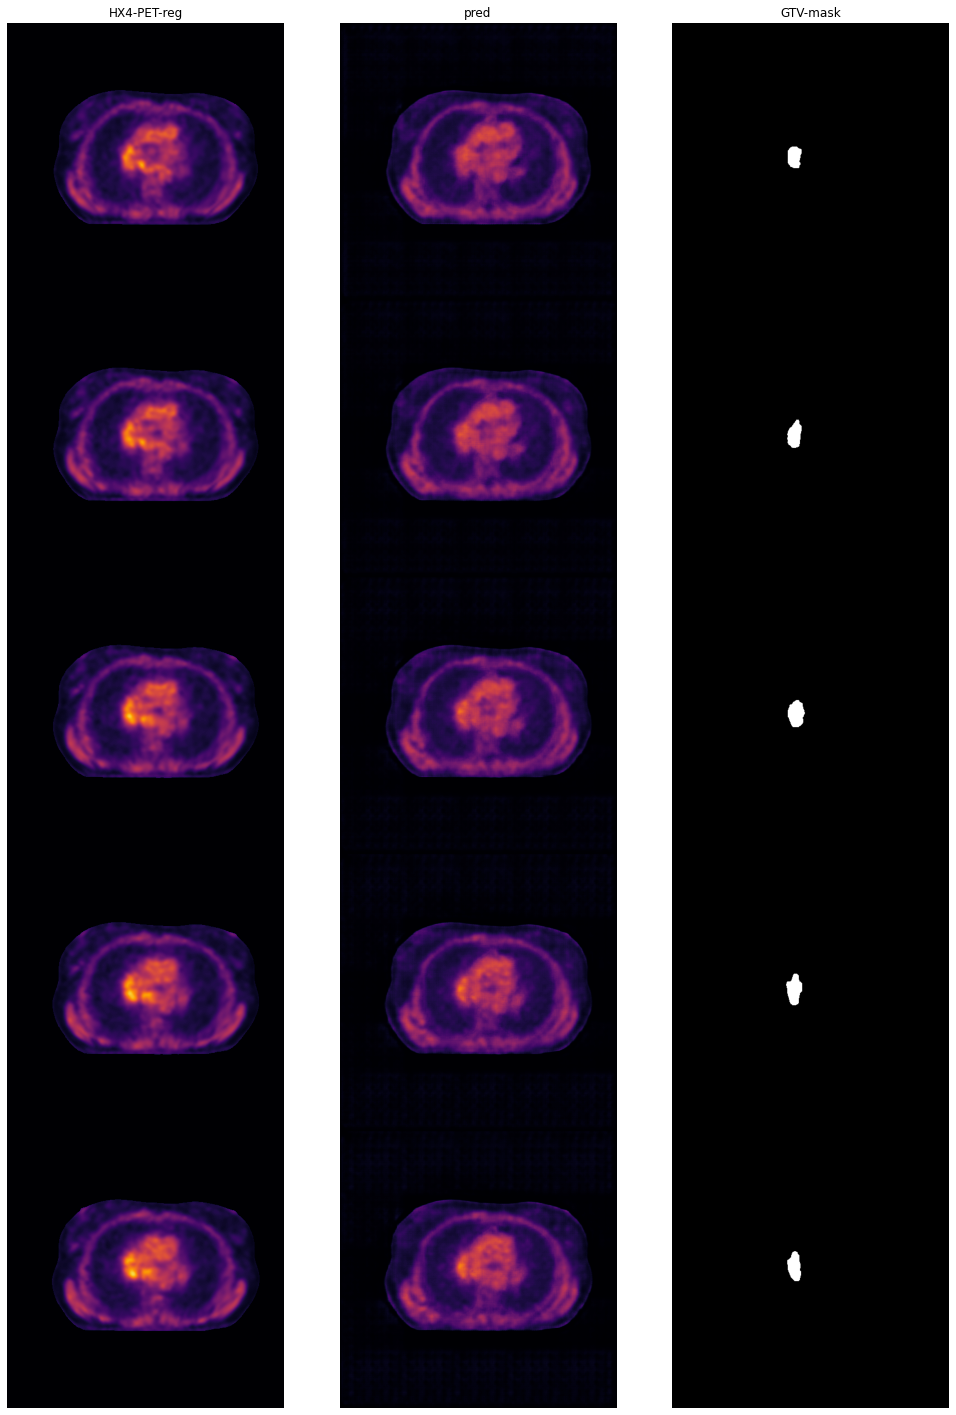

In [16]:
print(pred.shape)
print(hx4_pet_reg.shape)

# Visualize
visualizer.set_spacing((1,1,3))
visualizer.multi_image_strips([hx4_pet_reg.transpose(2,1,0), pred.transpose(2,1,0), gtv_mask.transpose(2,1,0)], 
                              image_types=['PET', 'PET', 'labelmap'], 
                              idx_range=[20, 25], 
                              view='axial',
                              subtitles=['HX4-PET-reg', 'pred', 'GTV-mask'])

(22, 67, 61)
(22, 67, 61)


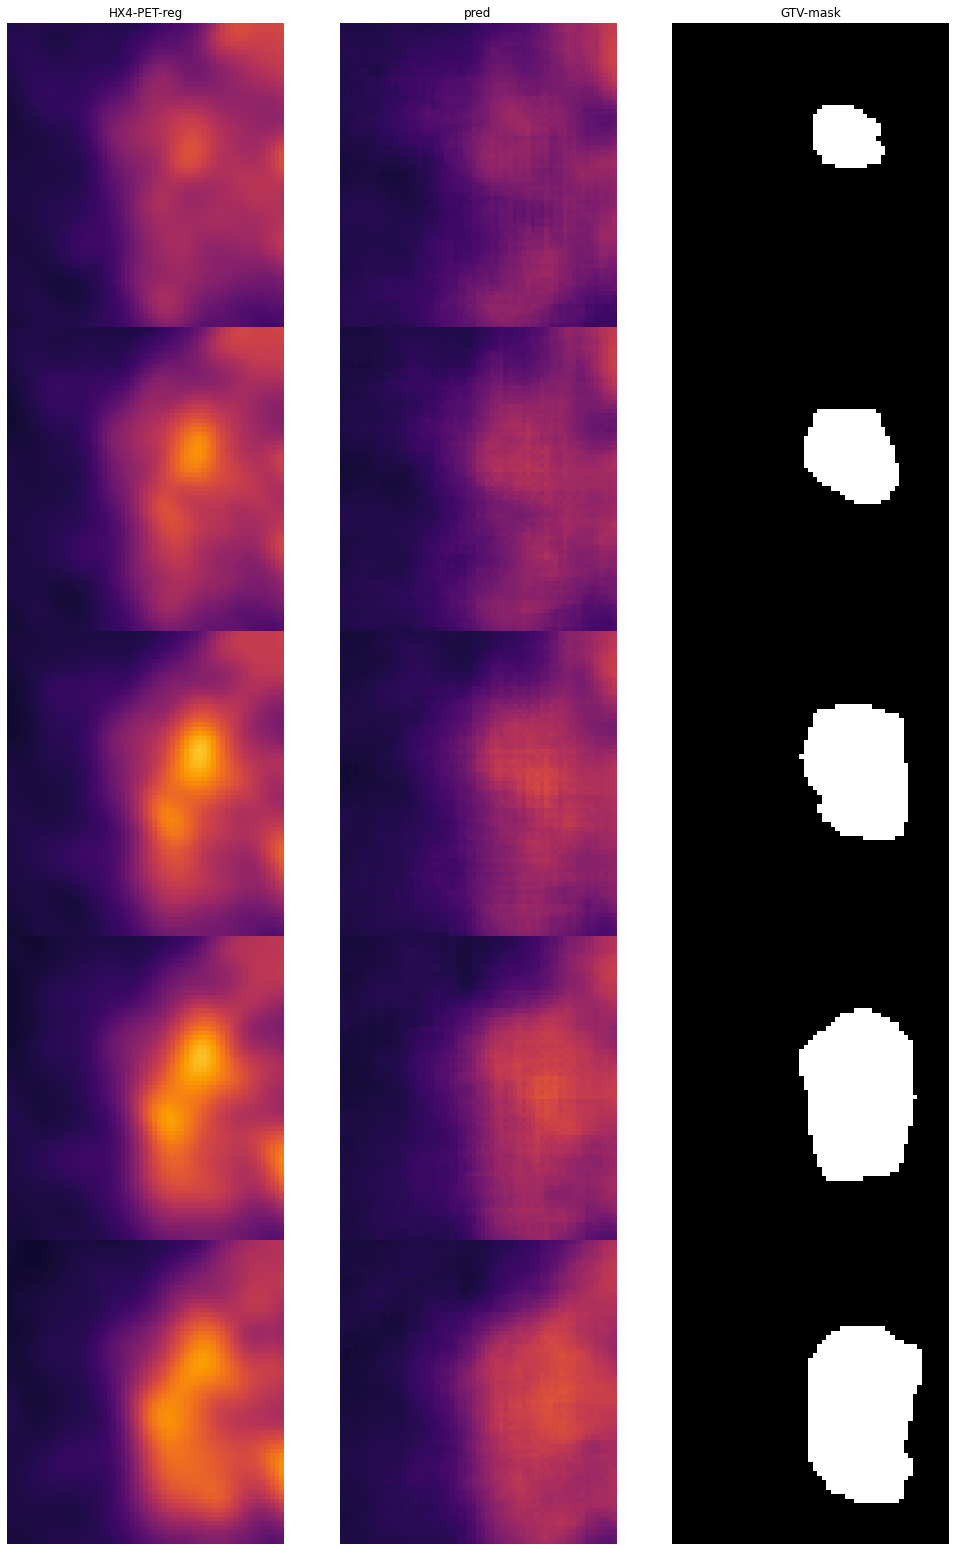

In [23]:
# Crop images to tumour size
pred = crop_image_to_tumour_size(pred, gtv_mask)
hx4_pet_reg = crop_image_to_tumour_size(hx4_pet_reg, gtv_mask)
gtv_mask = crop_image_to_tumour_size(gtv_mask, gtv_mask)

print(pred.shape)
print(hx4_pet_reg.shape)

# Visualize
visualizer.set_spacing((1,1,3))
visualizer.multi_image_strips([hx4_pet_reg.transpose(2,1,0), pred.transpose(2,1,0), gtv_mask.transpose(2,1,0)], 
                              image_types=['PET', 'PET', 'labelmap'], 
                              idx_range=[0, 5], 
                              view='axial',
                              subtitles=['HX4-PET-reg', 'pred', 'GTV-mask'])

### Calculate metrics

In [29]:
pred_masked = create_masked_array(pred, gtv_mask)
hx4_pet_reg_masked = create_masked_array(hx4_pet_reg, gtv_mask)

mse_gtv = mse(hx4_pet_reg_masked, pred_masked)
ssim_gtv = ssim(hx4_pet_reg_masked, pred_masked)

print("MSE-GTV:", mse_gtv)
print("SSIM-GTV", ssim_gtv)

MSE-GTV: 0.20186246745356465
SSIM-GTV 0.9376598739512324


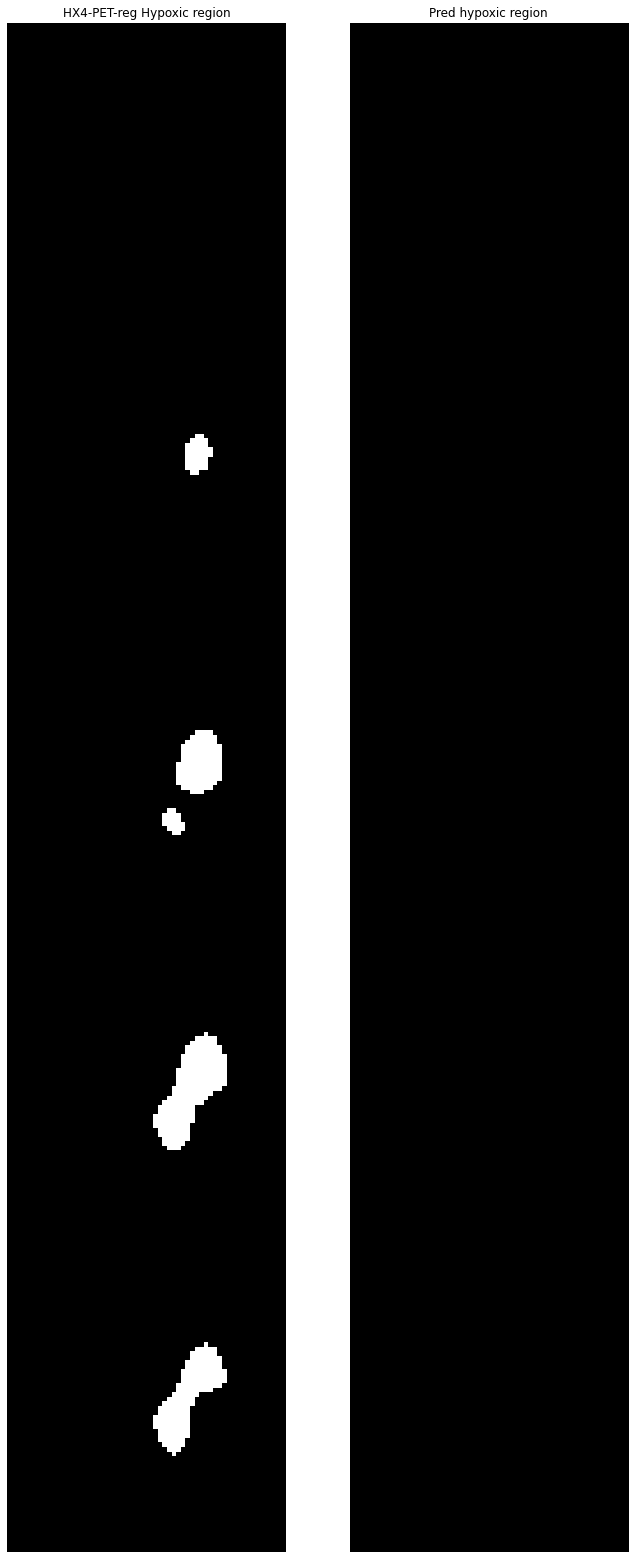

In [35]:
"""
TBR threshold of 1.4 used in Zegers (2013)(Optimal imaging parameters) to segment hypoxic region. 
Also used in Sanduleanu (2020)(Radiomic signatures) for 4h p.i. images 

Hypoxic volume threshold of 1cm3 used in Even (2017)(Predicting tumour hypoxia) for tumour classification.
An alternative to using a hypoxia volume threshold to classify tumour as hypoxic/non-hypoxic is thresholding 
the TBRmax within the tumour (used in Zegers (2013)). But this method isn't robust since it'll cause 
false positive if even a single voxel in the predicted image overshoots.
"""

TBR_THRESHOLD = 1.4 
HYPOXIC_VOLUME_THRESHOLD = 1000 / (1.0 * 1.0 * 3.0)  # 1000 mm3 / voxel size. 

# Segment hypoxic region WITHIN the tumour
pred_hypoxia_seg = pred * gtv_mask
pred_hypoxia_seg = pred_hypoxia_seg > TBR_THRESHOLD

hx4_pet_reg_hypoxia_seg = hx4_pet_reg * gtv_mask 
hx4_pet_reg_hypoxia_seg = hx4_pet_reg_hypoxia_seg > TBR_THRESHOLD

# Visualize
visualizer.set_spacing((1,1,3))
visualizer.multi_image_strips([hx4_pet_reg_hypoxia_seg.transpose(2,1,0), pred_hypoxia_seg.transpose(2,1,0)], 
                              image_types=['labelmap', 'labelmap'], 
                              idx_range=[0, 5], 
                              view='axial',
                              subtitles=['HX4-PET-reg Hypoxic region', 'Pred hypoxic region'])

In [41]:
pred_hv = np.sum(pred_hypoxia_seg) # Hypoxic volume.
pred_hf = pred_hv / np.sum(gtv_mask)  # Hypoxic fraction.  Use only one of them. 
pred_gtv_hypoxic = pred_hv > HYPOXIC_VOLUME_THRESHOLD  # Using HV

gt_hv = np.sum(hx4_pet_reg_hypoxia_seg)
gt_hf = gt_hv / np.sum(gtv_mask)
gt_gtv_hypoxic = gt_hv > HYPOXIC_VOLUME_THRESHOLD

# Calculate Dice score 
hypoxia_seg_dice = dice_score(pred_hypoxia_seg, hx4_pet_reg_hypoxia_seg)

print("Predicted:")
print("\tHV (voxels):", pred_hv)
print("\tHF (%):", pred_hf * 100)
print("\tGTV hypoxic?: ", pred_gtv_hypoxic)

print("Ground truth:")
print("\tHV (voxels):", gt_hv)
print("\tHF (%):", gt_hf * 100)
print("\tGTV hypoxic?: ", gt_gtv_hypoxic)

print("Hypoxia seg Dice:", hypoxia_seg_dice)

Predicted:
	HV (voxels): 86
	HF (%): 0.6287928639321488
	GTV hypoxic?:  False
Ground truth:
	HV (voxels): 2603
	HF (%): 19.03195145134167
	GTV hypoxic?:  True
Hypoxia seg Dice: 0.007437709185570844
